# Cursive Handwriting OCR

In [1]:
import numpy as np
import cv2 # OpenCV
import matplotlib
import matplotlib.pyplot as plt
import collections
import math
import os
import random
import shutil

from scipy import ndimage
# iscrtavanje slika u notebook-u
%matplotlib inline
# prikaz vecih slika
matplotlib.rcParams['figure.figsize'] = 16,12
# keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# Marija

def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def display_image(image, color=False):
    if color:
        plt.figure()
        plt.imshow(image)
    else:
        plt.figure()
        plt.imshow(image, 'gray')

def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def image_bin(image_gs):                                                    # gs -> gray scale
    height, width = image_gs.shape[0:2]                                     # [0,2] uzimamo prve dve vrednosti -> visinu i sirinu
    
    image_bin = cv2.adaptiveThreshold(image_gs, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 10)
    return image_bin

def invert(image):
    return 255-image

def dilate(image):                                                          # prosiruje bele delove slike
    kernel = np.ones((3, 3))                                                # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)

def erode(image):                                                           # smannjuje bele delove slike
    kernel = np.ones((3, 3))                                                # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

def open(image):                                                            #otvaranje = erozija + dilacija
    return erode(dilate(image))                                             #uklanjanje šuma erozijom i vraćanje originalnog oblika dilacijom

def close(image):                                                           #zatvaranje = dilacija + erozija,
    return dilate(erode(image))                                             #zatvaranje sitnih otvora među belim pikselima

def resize_region(region):
    return cv2.resize(region, (36, 36), interpolation=cv2.INTER_NEAREST)

def matrix_to_vector(image):                                                #pretvara sliku u vektoru
    return image.flatten()

def scale_to_range(image):                                                  #skalira boje sa opsega [0, 255] na [0, 1]   
    return image/255


In [3]:
# Nenad
# Ćelija u kojoj se nalazi kod koji se koristi za spajanje ROI koji se nalaze na trening podacima

def select_roi_training(image_orig, image_bin):
    contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    regions_array = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        region = image_bin[y:y+h+1, x:x+w+1]
        regions_array.append([resize_region(region), (x, y, w, h)])

    # Konture koje sadrze kukice
    connected_regions = [] 
    # Prolazimo kroz niz i proveravamo da li u ostatku niza postoji neki region iznad ili ispod trenutnog i ako 
    # postoji takav region, pravimo jedan veci region oko njih i dodajemo ga
    for region1, (x1, y1, w1, h1) in regions_array:
        for _region2, (x2, y2, w2, h2) in regions_array:
            # Provera da li je isti region
            if (x1, y1, w1, h1) == (x2, y2, w2, h2):
                continue
            mid_x2 = x2 + w2 // 2

            # Provera da li je region kvacica
            if (y1 >= y2 or y1 <= y2) and mid_x2 >= x1 and mid_x2 <= x1 + w1:
                x3, y3, w3, h3 = min(x1, x2), y2, max(w1, w2), h1+(y1-y2)
                region3 = image_bin[y3:y3+h3+1, x3:x3+w3+1]
                connected_regions.append([resize_region(region3), (x3, y3, w3, h3)])

    # Sad cemo proci kroz niz regions_array i videti da li se centar tih objekata nalazi unutar 
    # nekog veceg koji je u connected_regions
    # Filtiramo regione tako da na primer za slovo ž sad imamo 2 regiona u regions_array i 1 veci
    # region u connected_regions
    # Ona 2 regiona ne dodajemo u filtrirane regione dok cemo 1 veci region dodati kasnije
    # Ako se nalazi, preskacemo taj objekat, a ako ne onda ga dodajemo u nov niz
    filtered_regions = []
    for region1, (x1, y1, w1, h1) in regions_array:
        mid_x1 = x1 + w1 // 2
        mid_y1 = y1 + h1 // 2
        is_in = False
        for _region2, (x2, y2, w2, h2) in connected_regions:
            if mid_x1 >= x2 and mid_x1 <= x2 + w2 and mid_y1 >= y2 and mid_y1 <= y2 + h2:
                is_in = True
        if not is_in:
            filtered_regions.append([region1, (x1, y1, w1, h1)])
    
    # Dodajemo i one velike regione u kojem su slova sa kukicama
    filtered_regions += connected_regions

    # Iscrtavamo sve te regione
    for _, (x, y, w, h) in filtered_regions:
        cv2.rectangle(image_orig, (x, y), (x + w, y + h), (255, 0, 0), 2)
        
    # Sortiramo niz u kojem su elementi [region, koordinate] po x koordinati
    filtered_regions = sorted(filtered_regions, key=lambda x: x[1][0])
    sorted_regions = [region[0] for region in filtered_regions]

    return image_orig, sorted_regions

In [4]:
# Marija

def create_ann(output_size):                                        #pravljenje neuronske mreze
    ann = Sequential()
    ann.add(Flatten(input_shape=(64, 64, 1)))  # Dodaj Flatten sloj
    ann.add(Dense(128, input_dim=1296, activation='sigmoid'))       #36x36 -> ulazni sloj ima 1296 neurona 
    ann.add(Dense(output_size, activation='sigmoid'))

    ann.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return ann

def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
    return ready_for_ann

def convert_output(alphabet):                                       #u sustini a je [1 0 0 ... ], b je [0, 1, 0..]
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))                            #napravimo niz nula
        output[index] = 1                                           #na redni broj slova u alfabetu ide 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

def train_ann(ann, train, validation, epochs):

    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=12,
            restore_best_weights=True
        )
    ]
    
    print("\nTraining started...")
    history = ann.fit(train, epochs=epochs, verbose=1, validation_data=validation, callbacks=callbacks)
    print("\nTraining completed...")
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    return ann

def winner(output):                                                                    # odredjuje pobednicki neuron, onaj  neuron
    return max(enumerate(output), key=lambda x: x[1])[0]                               # cija je aktivaciona vrednost najveca

def display_result_with_spaces(outputs, alphabet, k_means):                                                          
    w_space_group = max(enumerate(k_means.cluster_centers_), key=lambda x: x[1])[0]    # odredjuje rastojanje izmedju reci (max)
                                                                                       # enumerate daje parove
    result = alphabet[winner(outputs[0])]
                                                                                                                        
    for idx, output in enumerate(outputs[1:, :]):
        if k_means.labels_[idx] == w_space_group:
            result += ' '
        result += alphabet[winner(output)]
    return result

In [5]:
# Nenad
# Ćelija u kojoj se nalazi algoritam za rotiranje slike
def rotate_image_to_normal(image, image_grayscale):
    image_edges = cv2.Canny(image_grayscale, 100, 100, apertureSize=3)
    lines = cv2.HoughLinesP(image_edges, 1, math.pi / 180.0, 100, maxLineGap=5)

    angles = []

    for [[x1, y1, x2, y2]] in lines:
        angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
        angles.append(angle)
    
    median_angle = np.median()
    image_rotated = ndimage.rotate(image, median_angle)

    return image_rotated

In [6]:
# Marija

def order_points(pts):                                                                                 # pomoćna funkcija, biće potrebna za correct_skewed_image
    rect = np.zeros((4, 2), dtype="float32")                                                           

    s = pts.sum(axis=1)                                                                               
    rect[0] = pts[np.argmin(s)]                                                                         # top-left (najmanji zbir x + y)
    rect[2] = pts[np.argmax(s)]                                                                         # bottom-right (najveći zbir x + y)

    diff = np.diff(pts, axis=1)                                                                        
    rect[1] = pts[np.argmin(diff)]                                                                      # top-right (najmanja razlika x - y)
    rect[3] = pts[np.argmax(diff)]                                                                      # bottom-left (najveća razlika x - y)

    return rect

def image_gray(image):                                                                                 # helper funkcija za konverziju u grayscale
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def correct_skewed_image(image):                                                                       # ispravlja slike slikane pod nekim uglom
    gray = image_gray(image)                                                                           
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)                                                         # blurujem da bih smanjila šum i lakše prepoznala ivice
    edges = cv2.Canny(blurred, 50, 150)                                                                 # detekcija ivica pomoću Canny algoritma

    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)                      
    contours = sorted(contours, key=cv2.contourArea, reverse=True)                                     # sortira konture od najveće do najmanje površine

    for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)                  # uprošćava se kontura
        if len(approx) == 4:
            screen_cnt = approx
            break
    else:
        return image                                                                                    # ako ne nađe konture, vrati original

    rect = order_points(screen_cnt.reshape(4, 2))                                                       # uredimo tačke
    (tl, tr, br, bl) = rect

    width_a = np.linalg.norm(br - bl)                                                                   # donja ivica
    width_b = np.linalg.norm(tr - tl)                                                                   # gornja ivica
    max_width = max(int(width_a), int(width_b))                                                         # širina ispravljene slike

    height_a = np.linalg.norm(tr - br)                                                                  
    height_b = np.linalg.norm(tl - bl)                                                                  
    max_height = max(int(height_a), int(height_b))                                                      # visina ispravljene slike

    dst = np.array([
        [0, 0],                                                                                          # gornji levi ugao
        [max_width - 1, 0],                                                                             # gornji desni
        [max_width - 1, max_height - 1],                                                                # donji desni
        [0, max_height - 1]                                                                             # donji levi
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)                                                          
    warped = cv2.warpPerspective(image, M, (max_width, max_height))                                    # slika se ispravlja

    return warped                                                                                       # vraćamo ispravljenu sliku


In [7]:
# Nenad
def select_roi_test():
    pass

In [8]:
# Marija

In [14]:
# Nenad
# Ćelija koja se koristi za kreiranje validacionih podataka na osnovu trening skupa

def pick_random_files(directory, count=3):
    all_items = os.listdir(directory)
    files = [f for f in all_items if os.path.isfile(os.path.join(directory, f))]
    
    # Pick random files
    if len(files) >= count:
        random_files = random.sample(files, count)
        return random_files
    else:
        return files
    
def create_validation_folder(training_folder, validation_folder):
    for character_name in os.listdir(training_folder):
        # Ako već postoji validacioni folder, onda nastavljamo na sledeći karakter
        if character_name in os.listdir(validation_folder):
            continue
        
        current_images_folder = training_folder + character_name + '/'
        new_validation_folder = validation_folder + character_name
        os.makedirs(new_validation_folder)  
        new_validation_folder += '/'

        files = pick_random_files(current_images_folder, count=3)
        for file in files:
                source_path = os.path.join(current_images_folder, file)
                destination_path = os.path.join(new_validation_folder, file)
                shutil.copy2(source_path, destination_path)

if 'val' not in os.listdir('../data/'):
    os.makedirs('../data/val')
    validation_folder = '../data/val/'
    training_folder = '../data/train/'
    create_validation_folder(training_folder, validation_folder)
    print("Succesfully created validation set!")
else:
    print("Validation set already exists!")

Succesfully created validation set!


In [10]:
# Marija

Found 11102 images belonging to 26 classes.
Found 78 images belonging to 26 classes.

Training started...
Epoch 1/100
694/694 [==============================] - 73s 105ms/step - loss: 3.2727 - accuracy: 0.0398 - val_loss: 3.2969 - val_accuracy: 0.0385
Epoch 2/100
694/694 [==============================] - 14s 19ms/step - loss: 3.2690 - accuracy: 0.0396 - val_loss: 3.3066 - val_accuracy: 0.0385
Epoch 3/100
694/694 [==============================] - 14s 20ms/step - loss: 3.2702 - accuracy: 0.0420 - val_loss: 3.2815 - val_accuracy: 0.0385
Epoch 4/100
694/694 [==============================] - 14s 20ms/step - loss: 3.2691 - accuracy: 0.0408 - val_loss: 3.2865 - val_accuracy: 0.0385
Epoch 5/100
694/694 [==============================] - 14s 20ms/step - loss: 3.2694 - accuracy: 0.0427 - val_loss: 3.2933 - val_accuracy: 0.0385
Epoch 6/100
694/694 [==============================] - 14s 20ms/step - loss: 3.2674 - accuracy: 0.0381 - val_loss: 3.2921 - val_accuracy: 0.0385
Epoch 7/100
694/694 [==

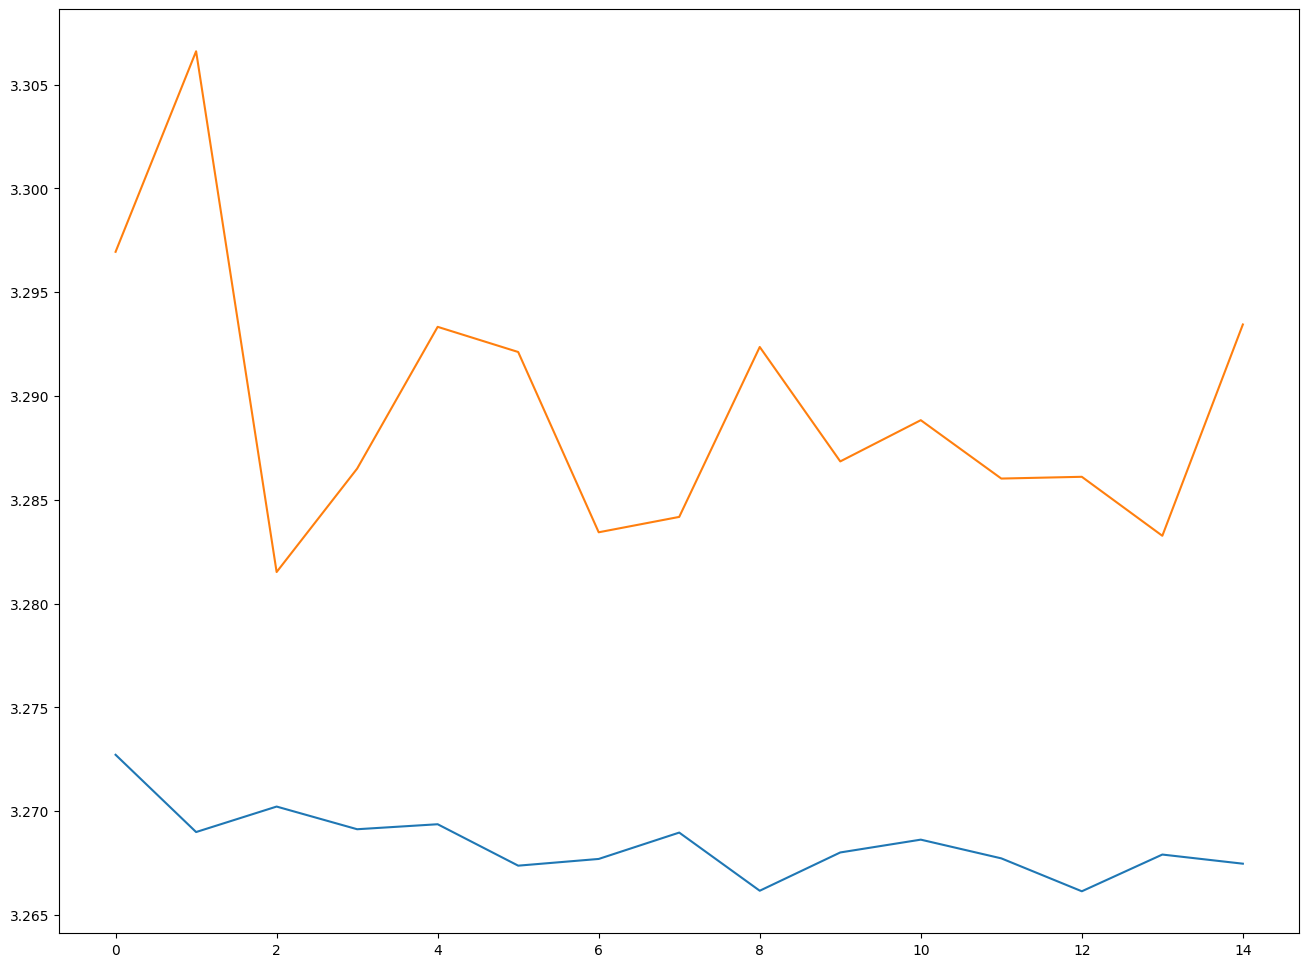

In [17]:
# Nenad
# Ideja je da folderi se nazivaju po indeksima karaktera koji su u nizu
# Primer: Velika slova B se nalaze u folderu 01, što je indeks tog karaktera u alfabetu
# Kako se budu dodavali karakteri ići će ovako redom:
# 1. Velika slova engleske latinice
# 2. Mala slova engleske latinice
# 3. Velika slova Č, Ć, Đ, Ž i Š 
# 4. Mala slova č, ć, đ, ž i š
# 5. Velika slova ćirilice
# 6. Mala slova ćirilice
# 7. Cifre
# 8. Znakovi interpunkcije
alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
            'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'
            ]

train_datagen = ImageDataGenerator(rotation_range=4)
validation_datagen = ImageDataGenerator(rescale=None) 

train_generator = train_datagen.flow_from_directory(
    '../data/train/',
    batch_size=16,
    color_mode='grayscale',
    target_size=(64, 64),
    class_mode='categorical'
)

# Bice korisceno kad budemo osmislili skup podataka
validation_generator = validation_datagen.flow_from_directory(
    '../data/val/',
    batch_size=16,
    color_mode='grayscale',
    target_size=(64, 64),
    class_mode='categorical'
)

ann = create_ann(output_size=(len(alphabet)))
ann = train_ann(ann, train_generator, validation_generator, epochs=100)

In [12]:
# Marija